<a href="https://colab.research.google.com/github/Kridr/HW_ML_HSE/blob/main/HW2_ML_HSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Выполнил: Ляликов Никита, мИИАД22

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
import collections

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Функции для расчета энтропии и прироста информации (5 баллов)

Пример для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [2]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

Дальше пусть шарики разбиваются на 2 группы

In [3]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

**Реализуйте функцию для расчета энтропии Шеннона.**

Моя собственная реализация

In [4]:
def entropy(a_list):
    counts = collections.Counter(a_list)
    s = 0
    for k in counts.keys():
        counts[k] /= len(a_list)
        s += counts[k]*np.log(counts[k])

    return -s

Реализация через scipy.stats.entropy (не моя) - для проверки

In [5]:
import scipy.stats as stats
def entropy1(labels, base=None):
  value, counts = np.unique(labels, return_counts=True)
  return stats.entropy(counts, base=base)

Проверка

In [6]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.6881388137135884
0.666278442414676
0.410116318288409
1.7917594692280547


Проверка (дополнительная)

In [7]:
print(entropy1(balls)) # 9 синих и 11 желтых
print(entropy1(balls_left)) # 8 синих и 5 желтых
print(entropy1(balls_right)) # 1 синий и 6 желтых
print(entropy1([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.6881388137135884
0.666278442414676
0.410116318288409
1.7917594692280547


Чему равна энтропия состояния, заданного списком `balls_left`?

In [8]:
print(entropy(balls_left))

0.666278442414676


Чему равна энтропия игральной кости с несмещенным центром тяжести?

In [9]:
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

1.7917594692280547


In [10]:
# расчет прироста информации

def information_gain(root, left, right):
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    return entropy(root) - (len(left) / len(root) * entropy(left) + len(right) / len(root) * entropy(right))

Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [11]:
information_gain(balls, balls_left, balls_right)

0.11151711474310588

Функция для выбора лучшего признака для разбиения

In [12]:
def best_feature_to_split(X, y):
    ''' Выводит прирост информации при разбиении по каждому признаку'''
    best_ig = 0
    best_feature = ''

    full_entropy = entropy(y)
    for feature in X.columns:
        #splitting
        #предполагаю, что я просто делю признак на все возможные значения.
        #то есть, я не делю лишь на два множества, как это необходимо в дереве поиска, 
        #а на количество множеств, равное уникальным значения.
        splits = []
        uniques = X[feature].unique()
        for unique in uniques:
            splits.append(y[X[feature] == unique])
        #Считаем энтропию для каждого разбиения
        splits_entropies = [entropy(split) for split in splits]
        #Считаем прирост информации. Функция, определенная выше, не подойдет 
        #(из-за отстутствия гарантий наличия только двух разбиений)
        ig = full_entropy - np.sum([splits_entropies[i] * len(splits[i]) / len(y) for i in range(len(splits))])
        print(f'Прирост информации для признака `{feature}`: {ig}')
        if ig > best_ig:
            best_ig = ig
            best_feature = feature
        
    print('----------------')
    print(f'Лучший прирост информации у признака `{feature}`: {ig}')

Сгенерируем датасет для проверки

In [13]:
df_test_1 = pd.DataFrame.from_dict(
    {
        'a': np.random.choice(3, size=20),
        'b': np.random.choice(2, size=20),
        'c': np.random.choice(6, size=20),
        'd': np.random.choice(3, size=20),
        'y': np.random.choice(2, size=20)
    },
    orient='columns'
)

df_test_1.head()

,a,b,c,d,y
0,2,0,2,0,0
1,0,1,0,1,1
2,1,0,3,2,1
3,1,1,0,1,0
4,0,0,3,0,0


Проверим результаты. Как видно, они сочетаются со здравым смыслом

In [14]:
best_feature_to_split(df_test_1.drop(columns=['y']), df_test_1['y'])

Прирост информации для признака `a`: 0.20704890090132694
Прирост информации для признака `b`: 0.029718579139346057
Прирост информации для признака `c`: 0.12856167933664475
Прирост информации для признака `d`: 0.09659274359280645
----------------
Лучший прирост информации у признака `d`: 0.09659274359280645


А теперь хард вариант. Сделаем выбор лучшего признака с лучшим бинарным разделением

In [15]:
def best_feature_and_predicate_to_split(X, y):
    ''' Выводит прирост информации при разбиении по каждому признаку'''
    best_ig = 0
    best_feature = ''

    for feature in X.columns:
        splits = []
        uniques = X[feature].unique()
        #Если больше 5 различных значений, то считаем переменную числовой
        #Иначе - категориальной
        best_split = None
        best_feature_ig = 0
        if len(uniques) > 5:
            #Перебираем все значения признака для создания бинарного предиката
            for val in uniques:
                left = y[X[feature] < val]
                right = y[X[feature] >= val]

                #Проверяем, что нет пустых разбиений
                if len(left) > 0 and len(right) > 0:
                    ig_split = information_gain(y, left, right)
                    if ig_split > best_feature_ig:
                        best_feature_ig = ig_split
                        best_split = f'< {val}'
        else:
            for val in uniques:
                left = y[X[feature] == val]
                right = y[X[feature] != val]

                ig_split = information_gain(y, left, right)
                if ig_split > best_feature_ig:
                    best_feature_ig = ig_split
                    best_split = f'== {val}'

        print(f'Наилучший прирост информации для признака `{feature}`: {best_feature_ig} (с предикатом `{best_split}`)')
        if best_feature_ig > best_ig:
            best_ig = best_feature_ig
            best_feature = feature
        
    print('----------------')
    print(f'Лучший прирост информации у признака `{feature}`: {best_ig}')

In [16]:
best_feature_and_predicate_to_split(df_test_1.drop(columns=['y']), df_test_1['y'])

Наилучший прирост информации для признака `a`: 0.20503802928608567 (с предикатом `== 1`)
Наилучший прирост информации для признака `b`: 0.029718579139345946 (с предикатом `== 0`)
Наилучший прирост информации для признака `c`: 0.0636755384412988 (с предикатом `< 5`)
Наилучший прирост информации для признака `d`: 0.08085026619609059 (с предикатом `== 2`)
----------------
Лучший прирост информации у признака `d`: 0.20503802928608567


Информация разумеется получилась немного меньше, так как делаем бинарное разбиение (для признака `b` осталась такой же, так как он и до этого был бинарный)

## 2. Деревья решений на наборе данных Adult (10 баллов)

**Описание набора:**

https://archive.ics.uci.edu/ml/datasets/adult (для ознакомления, а сами данные adult_train, adult_test располагаются в папке datasets на нашем GitHub):

Классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более 50 000 \$ в год.

Описание признаков: 

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак  

**Считываем обучающую и тестовую выборки.**

Думаю, что при наличии интернета лучше напрямую читать с Гитхаба

In [17]:
data_train = pd.read_csv('https://raw.githubusercontent.com/amhtj/ML-HSE/main/datasets/adult_train.csv', sep=';')
data_train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Здесь также поправил ошибку с данным (см. вторую строку в csv файле)

In [18]:
data_test = pd.read_csv('https://raw.githubusercontent.com/amhtj/ML-HSE/main/datasets/adult_test.csv', sep=';', skiprows=lambda x: x == 1) 
data_test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
4,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


Предобработка

Далее по сути нужно запускать ячейки. Чтобы я тоже проделал какую-то работу на этом этапе, я сделаю более оптимизированный и красивый код в некоторых местах

In [19]:
# необходимо убрать строки с неправильными метками в тестовой выборке
# data_test = data_test[(data_test['Target'] == ' >50K.') 
#                       | (data_test['Target']==' <=50K.')]
data_train = data_train[data_train['Target'].isin([' >50K', ' <=50K'])]
data_test = data_test[data_test['Target'].isin([' >50K.', ' <=50K.'])]

# перекодируем target в числовое поле
# data_train.at[data_train['Target'] == ' <=50K', 'Target'] = 0
# data_train.at[data_train['Target'] == ' >50K', 'Target'] = 1

# data_test.at[data_test['Target'] == ' <=50K.', 'Target'] = 0
# data_test.at[data_test['Target'] == ' >50K.', 'Target'] = 1
data_train['Target'] = np.where(data_train['Target'] == ' <=50K', 0, 1)
data_test['Target'] = np.where(data_test['Target'] == ' <=50K.', 0, 1)

Визуально посмотрим на изменения

In [20]:
data_train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [21]:
data_test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0


**Первичный анализ данных.**

In [22]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281.0,NaN,NaN,NaN,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Подсчет таргетов

In [23]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

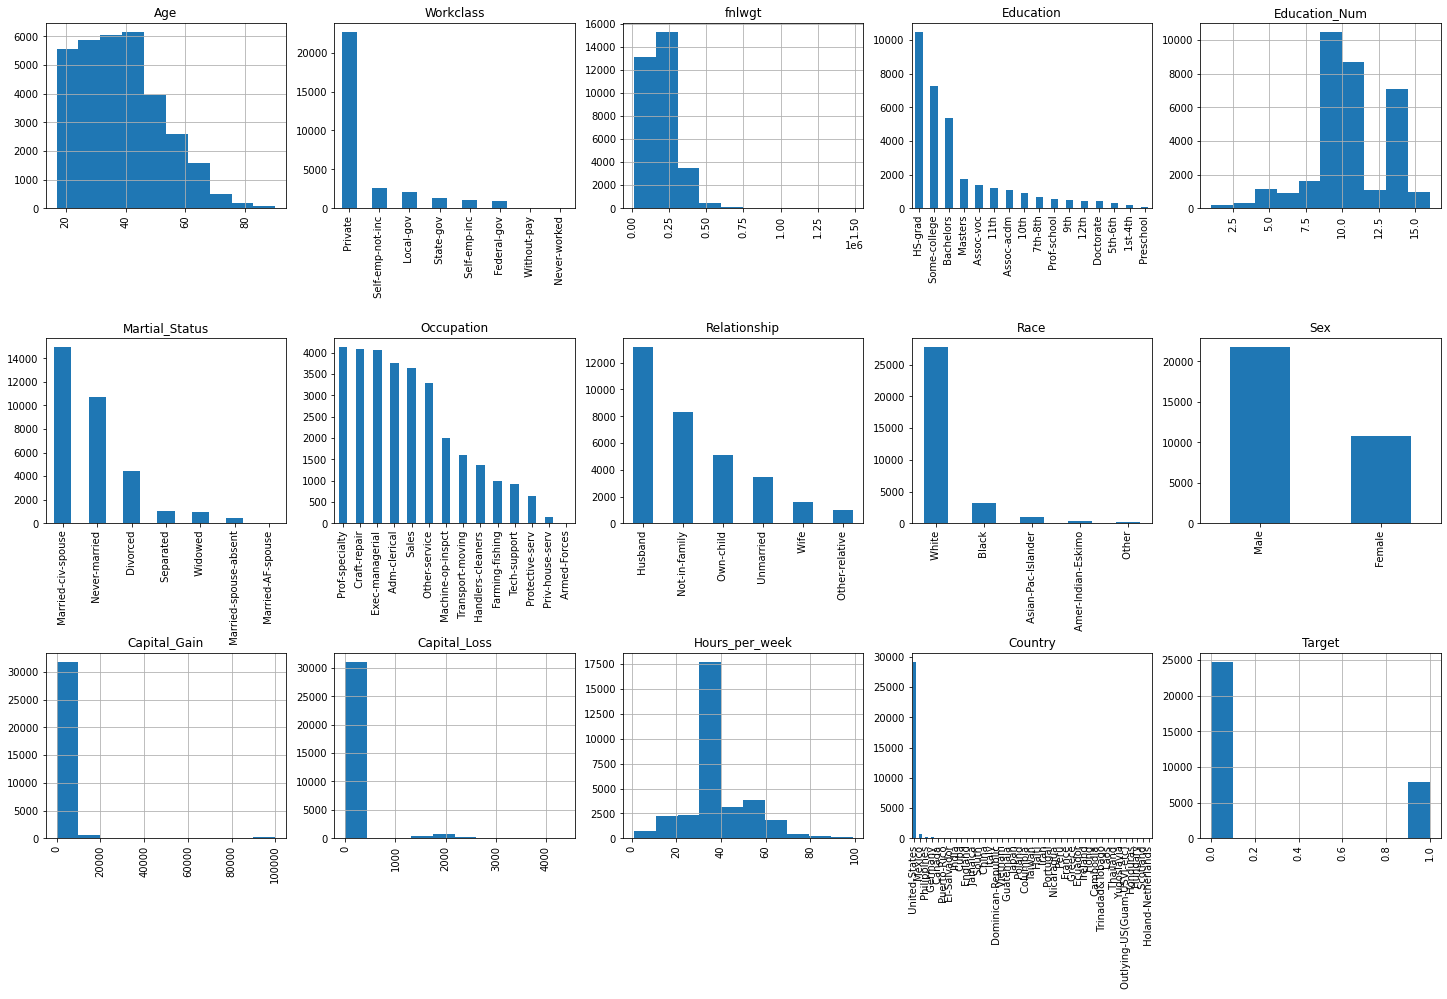

In [24]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Проверяем типы данных**

In [25]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [26]:
data_test.dtypes

Age                 int64
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

Комментарий: это из-за лишней строки

In [27]:
# data_test['Age'] = data_test['Age'].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [28]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением**

In [29]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [30]:
# заполним пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

**Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.**

In [31]:
def transform_categorical(data):
    data_copy = pd.concat([
        data, 
        pd.get_dummies(data['Workclass'], prefix="Workclass"),
        pd.get_dummies(data['Education'], prefix="Education"),
        pd.get_dummies(data['Martial_Status'], prefix="Martial_Status"),
        pd.get_dummies(data['Occupation'], prefix="Occupation"),
        pd.get_dummies(data['Relationship'], prefix="Relationship"),
        pd.get_dummies(data['Race'], prefix="Race"),
        pd.get_dummies(data['Sex'], prefix="Sex"),
        pd.get_dummies(data['Country'], prefix="Country")
        ],
        axis=1
    )

    data_copy.drop(
        [
         'Workclass', 
         'Education', 
         'Martial_Status',
         'Occupation', 
         'Relationship', 
         'Race', 
         'Sex', 
         'Country'
         ],
        axis=1, 
        inplace=True
    )

    return data_copy

In [32]:
# data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
#                                                    prefix="Workclass"),
#                       pd.get_dummies(data_train['Education'], prefix="Education"),
#                       pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
#                       pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
#                       pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
#                       pd.get_dummies(data_train['Race'], prefix="Race"),
#                       pd.get_dummies(data_train['Sex'], prefix="Sex"),
#                       pd.get_dummies(data_train['Country'], prefix="Country")],
#                      axis=1)

# data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
#                       pd.get_dummies(data_test['Education'], prefix="Education"),
#                       pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
#                       pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
#                       pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
#                       pd.get_dummies(data_test['Race'], prefix="Race"),
#                       pd.get_dummies(data_test['Sex'], prefix="Sex"),
#                       pd.get_dummies(data_test['Country'], prefix="Country")],
#                      axis=1)

In [33]:
# data_train.drop(['Workclass', 'Education', 'Martial_Status',
#                  'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
#                 axis=1, inplace=True)
# data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
#                 'Relationship', 'Race', 'Sex', 'Country'],
#                axis=1, inplace=True)

In [34]:
data_train = transform_categorical(data_train)
data_test = transform_categorical(data_test)

Посмотрим на описание данных после преобразования

In [35]:
data_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...
Country_ Thailand,16281.0,0.000737,0.027140,0.0,0.0,0.0,0.0,1.0
Country_ Trinadad&Tobago,16281.0,0.000491,0.022162,0.0,0.0,0.0,0.0,1.0
Country_ United-States,16281.0,0.900559,0.299262,0.0,1.0,1.0,1.0,1.0
Country_ Vietnam,16281.0,0.001167,0.034143,0.0,0.0,0.0,0.0,1.0


Посмотрим разницу между множествами признаков трейна и теста

In [36]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [37]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.**

In [38]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [39]:
set(data_train.columns) - set(data_test.columns)

set()

Теперь признаки соответствуют

In [40]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [41]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
0,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


In [42]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

## 2.1. Дерево решений без настройки параметров (5 баллов)

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.**

In [43]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train) #обучаем дерево трейн-данных

DecisionTreeClassifier(max_depth=3, random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [44]:
tree_predictions = tree.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [45]:
accuracy = accuracy_score(y_test, tree_predictions)

Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

In [46]:
print(accuracy)

0.8447884036607088


## 2.2. Дерево решений с настройкой параметров (5 баллов)

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`.**

In [47]:
tree_params = {'max_depth': range(2, 11)}

dtc = DecisionTreeClassifier(random_state=17)
#По-хорошему нужно еще вручную определить параметр cv с перемешиванием
locally_best_tree = GridSearchCV(dtc, tree_params, scoring='accuracy', n_jobs=-1)                     

#В этом случае, я обучусь на трейне, 
#так как в противном случае можем "настроиться" на тестовую выборку
locally_best_tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(2, 11)}, scoring='accuracy')

In [48]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8562698879315647


**Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.**

In [49]:
tuned_tree = DecisionTreeClassifier(random_state=17, **locally_best_tree.best_params_)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_tuned = accuracy_score(y_test, tuned_tree_predictions)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

In [50]:
accuracy_tuned

0.8471838339168356

Прирост достаточно маленький

# 3. Логистическая регрессия в задаче кредитного скоринга (15 баллов)



#### Данные представлены следующим образом (credit_scoring_sample из наших datasets на GitHub):

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [51]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [52]:
## Считываем данные 
# прописать путь в зависимости от того, где выполняете работу
data = pd.read_csv("https://raw.githubusercontent.com/amhtj/ML-HSE/main/datasets/credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [53]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

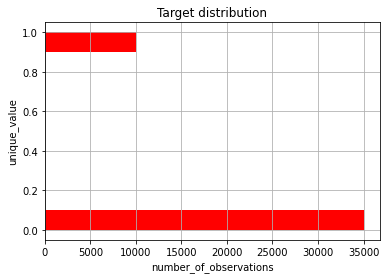

In [54]:
## Посмотрим на распределение классов в зависимой переменной

ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [55]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

# independent_columns_names = data.columns.values # не понятен смысл этой строчки
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Определим функцию для следующей ячейки

In [56]:
def delete_nan(data):
    data_c = data.copy()#Чтобы возвратить копию, а не изменять данные
    for col in data_c.columns:
        data_c[col].fillna(data_c[col].median(), inplace=True)
    return data_c

In [57]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)

In [58]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Используем модуль LogisticRegression для построения логистической регрессии.
# Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
# Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")

# Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
# Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
# и будет хорошо предсказывать значения таргета, с другой.
# Остальные параметры оставляем по умолчанию.
parameters = {'C': [10**i for i in range(-4, 2)]}#{"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

# Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
# значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [60]:
gscv = GridSearchCV(lr, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
gscv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             n_jobs=-1, param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring='roc_auc')

Выведем результаты в виде датафрейма

In [61]:
cv_res = pd.DataFrame.from_dict(gscv.cv_results_, orient='columns').sort_values('rank_test_score')
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.654033,0.144060,0.015707,0.004833,0.001,{'C': 0.001},0.809177,0.817956,0.795304,0.805826,0.816298,0.808912,0.008138,1
2,0.428016,0.102589,0.007628,0.000196,0.01,{'C': 0.01},0.809299,0.794199,0.798213,0.806224,0.816553,0.804898,0.007952,2
5,0.465478,0.122820,0.006987,0.001003,10,{'C': 10},0.791741,0.804959,0.798604,0.806269,0.801034,0.800522,0.005173,3
3,0.628368,0.215616,0.011437,0.004729,0.1,{'C': 0.1},0.791701,0.793950,0.798566,0.806264,0.801002,0.798296,0.005163,4
4,0.935180,0.172306,0.013098,0.003654,1,{'C': 1},0.783843,0.795147,0.798600,0.806269,0.792413,0.795255,0.007359,5
0,0.936027,0.144562,0.013351,0.006944,0.0001,{'C': 0.0001},0.779847,0.787592,0.786354,0.802098,0.790363,0.789251,0.007292,6


In [62]:
# Можно ли считать лучшую модель устойчивой? 
# (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) 
# Cохраните точность лучшей модели, она вам приходится для следующих заданий

In [63]:
if cv_res.iloc[0].std_test_score * 100 >= 0.5:
    print('Модель не устойчива')
else:
    print('Модель устойчивая')

Модель не устойчива


In [64]:
best_gscv_lr_score = cv_res.iloc[0].mean_test_score
best_gscv_lr_score

0.8089120626797153

Дополнительно сделаю еще одну кросс-валидацию. Теперь уже с нормализированными данными. Думаю будет интересно сравнить как влияет нормализация

In [65]:
from sklearn.preprocessing import StandardScaler

In [66]:
X_s = StandardScaler().fit_transform(X)

lr_s = LogisticRegression(random_state=5, class_weight="balanced")

parameters_s = {'C': [10**i for i in range(-4, 2)]}#{"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

skf_s = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [67]:
gscv_s = GridSearchCV(lr_s, parameters_s, scoring='roc_auc', cv=skf_s, n_jobs=-1)
gscv_s.fit(X_s, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             n_jobs=-1, param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring='roc_auc')

In [68]:
cv_res_s = pd.DataFrame.from_dict(gscv_s.cv_results_, orient='columns').sort_values('rank_test_score')
cv_res_s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.177952,0.013104,0.005173,0.000691,10,{'C': 10},0.785707,0.790474,0.790671,0.782783,0.790141,0.787955,0.003172,1
4,0.180288,0.008631,0.005640,0.000319,1,{'C': 1},0.785673,0.790326,0.790522,0.782586,0.790062,0.787834,0.003182,2
3,0.182505,0.006363,0.005384,0.000134,0.1,{'C': 0.1},0.784946,0.788756,0.789030,0.780563,0.789075,0.786474,0.003340,3
2,0.180263,0.017244,0.005848,0.000416,0.01,{'C': 0.01},0.773066,0.773189,0.774880,0.763414,0.775874,0.772084,0.004462,4
1,0.100976,0.005750,0.006118,0.000938,0.001,{'C': 0.001},0.713953,0.707774,0.712371,0.696758,0.715434,0.709258,0.006758,5
0,0.077386,0.004829,0.006628,0.001973,0.0001,{'C': 0.0001},0.669749,0.663772,0.665689,0.650613,0.673345,0.664634,0.007752,6


In [69]:
if cv_res_s.iloc[0].std_test_score * 100 >= 0.5:
    print('Модель не устойчива')
else:
    print('Модель устойчивая')

Модель устойчивая


In [70]:
best_gscv_lr_score_s = cv_res_s.iloc[0].mean_test_score
best_gscv_lr_score_s

0.7879554008449021

Как видно, нормализация только ухудшила результаты. Думаю это связано с тем, что есть признаки, которые почти всегда равны нулю, но при этому иногда имеют достаточно большие значения (например DebtRatio)

Но зато теперь модель устойчива

## 3.1 Определение влияния признаков (5 баллов) 

Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [71]:
abs_coefs = np.abs(gscv_s.best_estimator_.coef_)[0]
print(f'Коэффициенты: \n\t{list(abs_coefs)}')
print(f'Признаки: \n\t{list(X.columns)}\n')

best_feature_idx = np.argmax(abs_coefs)
print(f'Лучший признак {X.columns[best_feature_idx]}')

Коэффициенты: 
	[0.4364955151484331, 3.277331692873595, 0.04233802908288247, 3.065581707907042, 0.07635991719190198, 0.2039664612795892, 0.08526609791621399]
Признаки: 
	['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'MonthlyIncome', 'NumberOfDependents']

Лучший признак NumberOfTime30-59DaysPastDueNotWorse


In [72]:
from scipy.special import softmax

In [73]:
# Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией softmax)
sm_res = softmax(abs_coefs)
print(list(sm_res))

print(f'Долю влияния DebtRatio на предсказание: ' + str(sm_res[list(X.columns).index('DebtRatio')]))

[0.028686700201528113, 0.491405565325658, 0.01934194631415822, 0.3976291553763768, 0.020011317925904572, 0.022734976505686007, 0.02019033835068831]
Долю влияния DebtRatio на предсказание: 0.01934194631415822


# 4. Случайный лес (5 баллов) 

In [74]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

## Будем искать лучшие параметры среди следующего набора
parameters_rf = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

## Делаем опять же k-fold валидацию.
skf_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
gscv_rf = GridSearchCV(rf, parameters_rf, scoring='roc_auc', cv=skf_rf, n_jobs=-1)
gscv_rf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [75]:
cv_res_rf = pd.DataFrame.from_dict(gscv_rf.cv_results_, orient='columns').sort_values('rank_test_score')
cv_res_rf.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,4.455368,0.114335,0.187299,0.010570,10,2,9,"{'max_depth': 10, 'max_features': 2, 'min_samp...",0.830987,0.840611,0.834135,0.834192,0.838968,0.835779,0.003513,1
23,6.802721,0.132022,0.185236,0.016466,10,4,9,"{'max_depth': 10, 'max_features': 4, 'min_samp...",0.830745,0.840488,0.834591,0.833649,0.839315,0.835758,0.003632,2
18,4.966593,0.494333,0.217095,0.048238,10,2,7,"{'max_depth': 10, 'max_features': 2, 'min_samp...",0.830917,0.840088,0.834060,0.833856,0.839408,0.835666,0.003520,3
17,4.541130,0.130754,0.203877,0.027985,10,2,5,"{'max_depth': 10, 'max_features': 2, 'min_samp...",0.830633,0.840004,0.833893,0.833412,0.838779,0.835344,0.003509,4
15,3.470366,0.067072,0.202638,0.013996,10,1,9,"{'max_depth': 10, 'max_features': 1, 'min_samp...",0.830420,0.839191,0.833976,0.834137,0.838900,0.835325,0.003317,5


In [76]:
best_gscv_rf_score = cv_res_rf.iloc[0].mean_test_score
best_gscv_rf_score

0.8357785379863423

In [77]:
# Насколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

print(f'Абсолютное улучшение: {best_gscv_rf_score - best_gscv_lr_score}')
print(f'Относительное улучшение: {(best_gscv_rf_score - best_gscv_lr_score) / best_gscv_lr_score}')

Абсолютное улучшение: 0.026866475306627002
Относительное улучшение: 0.03321309762352333


Влияние признаков

In [78]:
# Какой признак имеет наименьшее влияние?

gscv_rf.best_estimator_.feature_importances_

array([0.11585997, 0.30028969, 0.0760817 , 0.27874902, 0.15653442,
       0.05799435, 0.01449085])

Соответствующие имена признаков

In [79]:
gscv_rf.best_estimator_.feature_names_in_

array(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
       'MonthlyIncome', 'NumberOfDependents'], dtype=object)

Признак, имеющий наименьшее влияние

In [80]:
gscv_rf.best_estimator_.feature_names_in_[np.argmin(gscv_rf.best_estimator_.feature_importances_)]

'NumberOfDependents'